<a href="https://www.kaggle.com/code/newarifooddetection/imgcolorizefeb8?scriptVersionId=162150310" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2
from tensorflow.keras import layers
from keras.models import Model, Sequential
from tensorflow.keras.applications import VGG19
from keras.layers import Dense, Conv2D, Flatten, BatchNormalization, LeakyReLU
from keras.layers import Conv2DTranspose, Dropout, ReLU, Input, Concatenate, ZeroPadding2D
from keras.optimizers import Adam
from keras.utils import plot_model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_addons as tfa


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) == 0:
    print("No GPU devices found. Make sure your GPU is properly installed and configured.")
else:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("GPU configured successfully.")

GPU configured successfully.


In [3]:
import tensorflow as tf

# Check available GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate GPU memory growth
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("GPU memory growth set to True")
    except RuntimeError as e:
        print(e)

GPU memory growth set to True


In [4]:
import tensorflow as tf

# Check if TensorFlow can access GPU
num_gpus = len(tf.config.experimental.list_physical_devices('GPU'))

if num_gpus > 0:
    print("Num GPUs Available: ", num_gpus)
    print("TensorFlow is using GPU.")
else:
    print("No GPU available. TensorFlow is using CPU.")

Num GPUs Available:  1
TensorFlow is using GPU.


In [5]:
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image,tf.float32)
    return image

In [6]:
path = "/kaggle/input/monumentimagenotaugmented/"
x = load(os.path.join(path, 'train/Train_3221.jpg'))
print(x.shape)

(300, 300, 3)


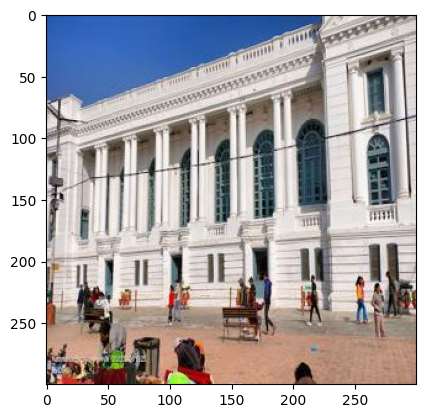

In [7]:
plt.imshow(x/255.0)

In [8]:
def normalize(real_image):
    real_image = (real_image / 255)
    return real_image

In [9]:
def random_crop(real_image):
    cropped_image = tf.image.random_crop(real_image, size = [256, 256, 3])
    return cropped_image

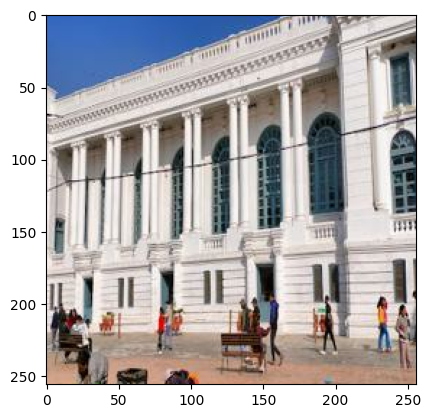

In [10]:
x_aug = random_crop(x)
plt.imshow(x_aug/255.0)

In [11]:
def resize(real_image):
    real_image = tf.image.resize(real_image, [256, 256], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return real_image

In [12]:
def rotate_image(image, angles, interpolation='BILINEAR'):
    """
    Rotate an image tensor by specified angles.

    Args:
    - image: Input image tensor with shape (batch_size, height, width, channels).
    - angles: Tensor of rotation angles in radians for each image in the batch.
    - interpolation: Interpolation method ('BILINEAR' or 'NEAREST').

    Returns:
    - Rotated image tensor.
    """
    batch_size, height, width, channels = tf.unstack(tf.shape(image))

    # Coordinates of the center of the image
    center_x = tf.cast(width, tf.float32) / 2.0
    center_y = tf.cast(height, tf.float32) / 2.0

    # Define transformation matrix
    rotation_matrix = tf.reshape(tf.stack([tf.cos(angles), -tf.sin(angles), center_x * (1 - tf.cos(angles)) + center_y * tf.sin(angles),
                                           tf.sin(angles), tf.cos(angles), -center_x * tf.sin(angles) + center_y * (1 - tf.cos(angles)),
                                           0.0, 0.0, 1.0], axis=1), shape=(-1, 3, 3))

    # Apply rotation to each pixel
    rotated_image = tfa.image.transform(image, rotation_matrix, interpolation)

    return rotated_image


In [13]:
def random_jitter(real_image):
    if tf.random.uniform(()) > 0.5:
        real_image = tf.image.flip_left_right(real_image)
    return real_image

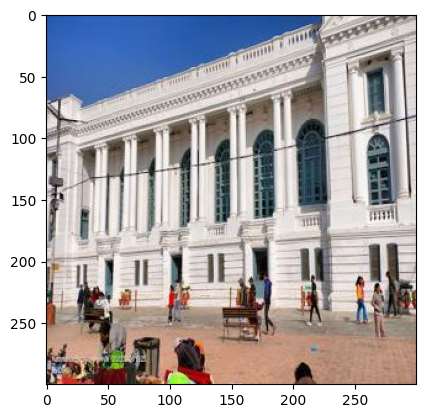

In [14]:
x_jitter = random_jitter(x)
plt.imshow(x_jitter/255.0)

In [15]:
def load_train_images(image_path):
    real_image = load(image_path)
    real_image = tf.image.random_brightness(real_image, 0.2)
    real_image = random_crop(real_image)
    # Define the rotation angle in radians
    rotation_angle = tf.constant(20.0 * (3.141592653589793 / 180.0), dtype=tf.float32)

    # Apply the rotation using tfa.image.rotate
    real_image = tfa.image.rotate(real_image, angles=rotation_angle)

#     # Example usage
#     angles = tf.placeholder(dtype=tf.float32, shape=(None,))
#     # Specify the rotation range in degrees
#     rotation_range = 15  # Adjust this value as needed
#     # Convert the rotation range to radians
#     rotation_range_rad = rotation_range * (np.pi / 180.0)
#     # Generate random rotation angles for each image in the batch
#     random_angles = tf.random.uniform(shape=(tf.shape(image)[0],), minval=-rotation_range_rad, maxval=rotation_range_rad)
#     # Apply custom rotation to the image with bilinear interpolation
#     real_image = rotate_image(real_image, random_angles, interpolation='BILINEAR')
    #     real_image = rotate(real_image)
    real_image = random_jitter(real_image)
    real_image = normalize(real_image)
    yuv_image = tf.image.rgb_to_yuv(real_image)
    # Separate LAB into L and AB components
    Y_channel = tf.expand_dims(yuv_image[:, :, 0], axis=-1)  # L channel
    UV_channels = yuv_image[:, :, 1:]  # AB channels
    #here L_channel becomes input i.e light/luminance of pixel and AB_channels become target
    return Y_channel, UV_channels

In [16]:
def load_test_image(image_path):
    real_image = load(image_path)
    real_image = resize(real_image)
    real_image = normalize(real_image)
    yuv_image = tf.image.rgb_to_yuv(real_image)
    # Separate LAB into L and AB components
    Y_channel = tf.expand_dims(yuv_image[:, :, 0], axis=-1)  # L channel
    UV_channels = yuv_image[:, :, 1:]  # AB channels
    #here L_channel becomes input i.e light/luminance of pixel and AB_channels become target
    return Y_channel, UV_channels

In [17]:
IMAGE_SIZE = 256
BATCH_SIZE = 8

In [18]:
# create input pipeline
train_dataset = tf.data.Dataset.list_files(path + "train/*.jpg")
train_dataset = train_dataset.map(load_train_images)
train_dataset = train_dataset.shuffle(10).batch(BATCH_SIZE)
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None))>

In [19]:
test_dataset = tf.data.Dataset.list_files(path + 'val/*.jpg')
test_dataset = test_dataset.map(load_test_image)
test_dataset = test_dataset.batch(BATCH_SIZE)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 2), dtype=tf.float32, name=None))>

In [20]:
# downsample block
def downsample(filters, size,dropout=False, batchnorm = True):
    init = tf.random_normal_initializer(0.,0.02)
    result = Sequential()
    result.add(Conv2D(filters, size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
    if batchnorm == True:
        result.add(BatchNormalization())
    if dropout == True :
        result.add(Dropout(0.3))
    result.add(LeakyReLU())
    return result
down_model = downsample(3,4)
down_result = down_model(tf.expand_dims(x, axis = 0))
print(down_result.shape)

(1, 150, 150, 3)


In [21]:
# upsample block
def upsample(filters, size, dropout = False):
    init = tf.random_normal_initializer(0, 0.02)
    result = Sequential()
    result.add(Conv2DTranspose(filters, size, strides = 2, padding = "same", kernel_initializer = init, use_bias = False))
    result.add(BatchNormalization())
    if dropout == True:
        result.add(Dropout(0.3))
    result.add(ReLU())
    return result
up_model = upsample(3,4)
up_result = up_model(down_result)
print(up_result.shape)

(1, 300, 300, 3)


In [22]:
def generator(input_shape = (256,256,1), output_channels = 2):
    inputs = Input(shape = input_shape)
    down_stack = [
        downsample(64, 4, batchnorm=False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4, dropout = True),
        downsample(512, 4, dropout = True),
        downsample(512, 4, dropout = True),
        downsample(512, 4, dropout = True),
        downsample(512, 4, dropout = True)
    ]


    up_stack = [
        upsample(512, 4, dropout=True),
        upsample(512, 4, dropout=True),
        upsample(512, 4, dropout=True),
        upsample(512, 4, dropout=True),
        upsample(256, 4, dropout=True),
        upsample(128, 4),
        upsample(64, 4),
    ]
    init = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(2, 4, strides = 2, padding = "same", kernel_initializer = init, activation ="tanh")
    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])

    x = last(x)
    return Model(inputs = inputs, outputs = x)

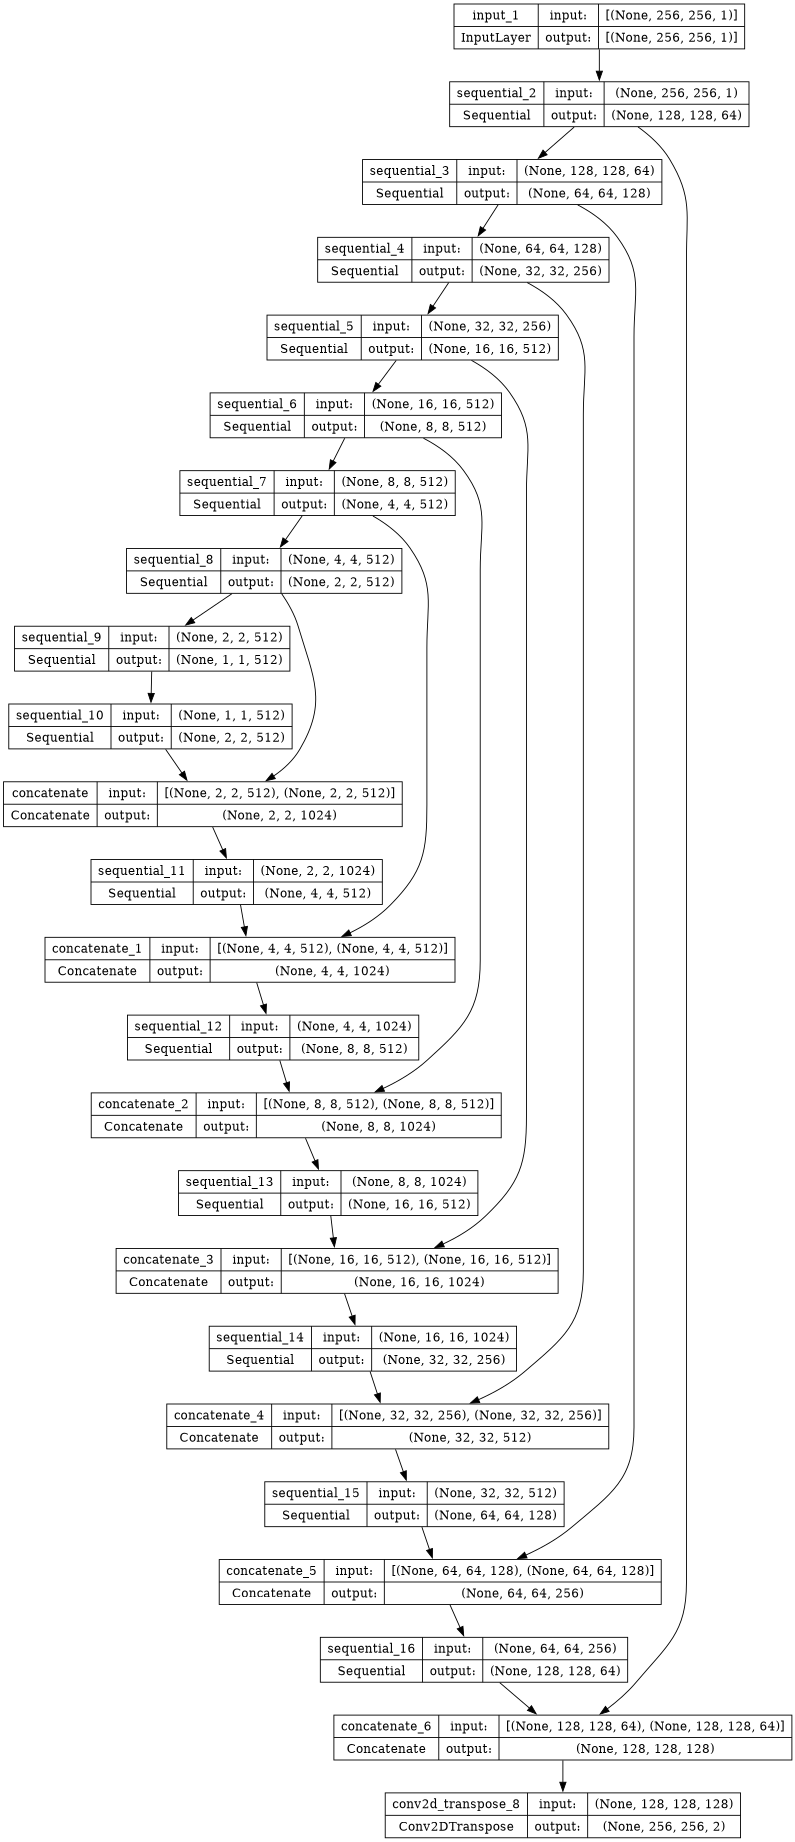

In [23]:
gen = generator()
plot_model(gen, show_shapes=True, dpi = 64)

In [24]:
def discriminator():
    init = tf.random_normal_initializer(0., 0.02)

    inp = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 1], name = "input_image")
    tar = Input(shape = [IMAGE_SIZE, IMAGE_SIZE, 2], name = "target_image")
    x = Concatenate()([inp, tar])
    down1 = downsample(64,4,False)(x)
    down2 = downsample(128, 4)(down1)
    down3 = downsample(256, 4)(down2)

    zero_pad1 = ZeroPadding2D()(down3)
    conv = Conv2D(256, 4, strides = 1, kernel_initializer = init, use_bias = False)(zero_pad1)
    leaky_relu = LeakyReLU()(conv)
    zero_pad2 = ZeroPadding2D()(leaky_relu)
    last = Conv2D(1, 4, strides = 1, kernel_initializer=init)(zero_pad2)
    return Model(inputs = [inp, tar], outputs = last)

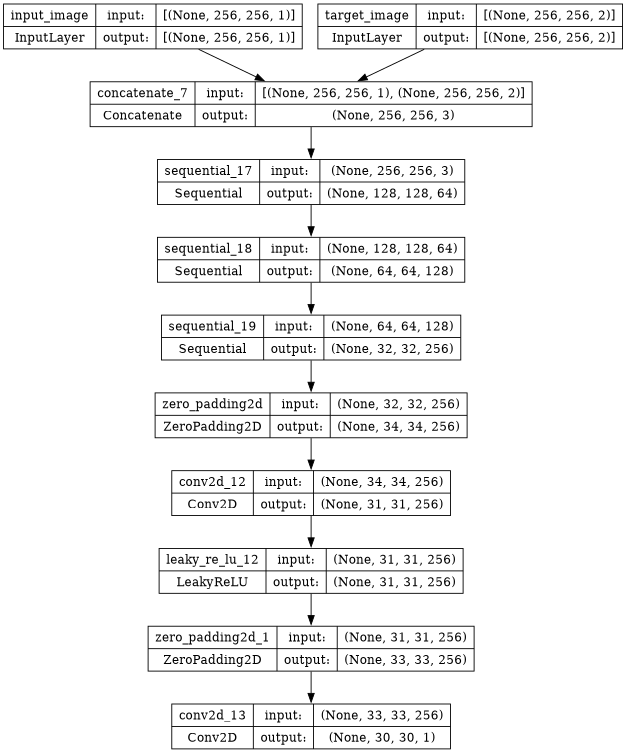

In [25]:
disc = discriminator()
plot_model(disc, show_shapes=True, dpi = 64)

In [26]:
# Function to create YUV image from Y, U, and V channels and then convert to rgb
def create_rgb_image(y_channel, uv_channel):
    # Assuming YUV format where Y, U, and V channels are separate
    # y_channel = np.array(y_channel)
    # uv_channel = np.array(uv_channel)
    u_channel, v_channel = tf.split(uv_channel, num_or_size_splits=2, axis=-1)

    # Combine Y, U, and V channels into a YUV image
    rgb_image = tf.image.yuv_to_rgb(tf.concat([y_channel, u_channel, v_channel], axis=-1))
    return rgb_image


In [27]:
LAMBDA = 30

In [28]:
# Define the perceptual loss function
def perceptual_loss(y_true, y_pred):
    vgg = VGG19(include_top=False, weights='imagenet', input_shape=(None, None, 3))
    vgg.trainable = False
    for layer in vgg.layers:
        layer.trainable = False
    model = Model(inputs=vgg.input, outputs=vgg.get_layer('block5_conv4').output)
    model.trainable = False

    y_true_features = model(y_true)
    y_pred_features = model(y_pred)

    return tf.reduce_mean(tf.square(y_true_features - y_pred_features))

In [29]:
def generator_loss(disc_generated_output,input_, gen_output, target):
    gan_loss = loss_function(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    p_loss = perceptual_loss(create_rgb_image(input_, gen_output), create_rgb_image(input_, target))
    total_gen_loss = gan_loss + (LAMBDA * l1_loss) + 50*p_loss
    return total_gen_loss, gan_loss, l1_loss, p_loss

In [30]:
from keras.losses import BinaryCrossentropy
loss_function = BinaryCrossentropy(from_logits=True)

In [31]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_function(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_function(tf.zeros_like(disc_generated_output), disc_generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss, real_loss, generated_loss

In [32]:
generator_optimizer = Adam(lr= 2e-4, beta_1=0.5)
discriminator_optimizer = Adam(lr = 2e-4, beta_1=0.5)

In [33]:
epochs = 250

In [34]:
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model

# Load the VGG19 model
vgg = VGG19(weights='imagenet', include_top=False)

# Select the layers you want to use for the LPIPS score
selected_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1']

# Create a model that outputs the selected layers
outputs = [vgg.get_layer(name).output for name in selected_layers]
model = Model(inputs=vgg.input, outputs=outputs)

# Make sure the VGG model is not trainable
model.trainable = False

def lpips_score(image1, image2):
    # Get the features for both images
    image1_features = model(image1)
    image2_features = model(image2)

    # Initialize the score
    score = 0

    # For each feature layer...
    for f1, f2 in zip(image1_features, image2_features):
        # ... compute the mean squared error between the features
        mse = tf.reduce_mean((f1 - f2)**2)
        # ... and add it to the score
        score += mse

    return score

80134624/80134624 [==============================] - 0s 0us/step


In [35]:
@tf.function
def train_step(input_image, target, epoch, training_discriminator):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = gen(input_image, training=True)
        disc_real_output = disc([input_image, target], training=True)
        disc_generated_output = disc([input_image, gen_output], training=True)
        gen_total_loss, gen_gan_loss, gen_l1_loss, gen_p_loss = generator_loss(disc_generated_output,input_image, gen_output, target)
        disc_loss, disc_real_loss, disc_generated_loss = discriminator_loss(disc_real_output, disc_generated_output)

        ssim_values = tf.image.ssim(create_rgb_image(input_image, target), create_rgb_image(input_image,gen_output), max_val=1.0)
        psnr_values = tf.image.psnr(create_rgb_image(input_image, target), create_rgb_image(input_image,gen_output), max_val=1.0)
        lpips_values = lpips_score(create_rgb_image(input_image, target), create_rgb_image(input_image,gen_output))

        if epoch > 8:
            if training_discriminator:
                discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
                discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))
            else:
                generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
                generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
        else:
            generator_gradients = gen_tape.gradient(gen_total_loss, gen.trainable_variables)
            discriminator_gradients = disc_tape.gradient(disc_loss, disc.trainable_variables)
            generator_optimizer.apply_gradients(zip(generator_gradients, gen.trainable_variables))
            discriminator_optimizer.apply_gradients(zip(discriminator_gradients, disc.trainable_variables))

        return gen_total_loss, gen_gan_loss, gen_l1_loss,gen_p_loss, disc_loss,disc_real_loss, disc_generated_loss, ssim_values, psnr_values, lpips_values

In [36]:
@tf.function
def test_step(input_image, target):
    # Generate output using the generator
    gen_output = gen(input_image)

    # Calculate losses without updating gradients
    disc_real_output = disc([input_image, target])
    disc_generated_output = disc([input_image, gen_output])

    gen_total_loss, gen_gan_loss, gen_l1_loss, gen_p_loss = generator_loss(disc_generated_output,input_image, gen_output, target)
    disc_loss,disc_real_loss, disc_generated_loss = discriminator_loss(disc_real_output, disc_generated_output)

    ssim_values = tf.image.ssim(create_rgb_image(input_image, target), create_rgb_image(input_image,gen_output), max_val=1.0)
    psnr_values = tf.image.psnr(create_rgb_image(input_image, target), create_rgb_image(input_image,gen_output), max_val=1.0)
    lpips_values = lpips_score(create_rgb_image(input_image, target), create_rgb_image(input_image,gen_output))

    #accuracy = calculate_accuracy(disc_generated_output, disc_real_output)
    return gen_total_loss, gen_gan_loss, gen_l1_loss,gen_p_loss, disc_loss,disc_real_loss, disc_generated_loss, ssim_values, psnr_values, lpips_values


In [37]:
os.mkdir('/kaggle/working/gen_output/')

In [38]:
def display_one_random_test_image(input_, target, gen_model, epoch):
    print("Displaying one random test image...")
    img_array = np.array(input_)
    generated_output_test = gen_model(input_)
    ssim = tf.image.ssim(tf.reshape(create_rgb_image(input_, target), (256,256,3)), tf.reshape(create_rgb_image(input_,generated_output_test), (256,256,3)), max_val=1.0)
    psnr = tf.image.psnr(tf.reshape(create_rgb_image(input_, target), (256,256,3)), tf.reshape(create_rgb_image(input_,generated_output_test), (256,256,3)), max_val=1.0)  
    lpips = lpips_score(tf.reshape(create_rgb_image(input_, target), (1,256,256,3)), tf.reshape(create_rgb_image(input_,generated_output_test), (1,256,256,3)))
    p_loss = perceptual_loss(create_rgb_image(input_, target), create_rgb_image(input_, generated_output_test))
    # print(input_.shape)
    input_ = np.squeeze(input_, axis=0)
    # print(type(input_), type(target))
    # print(input_.shape, input_)
    # input_.reshape((256,256))
    plt.figure(figsize=(16, 16))
    plt.subplot(1, 4, 1)
    plt.title('Input Testing Image')
    plt.imshow(input_, cmap='gray', vmax = 1, vmin = 0)  # Assuming images are normalized to [0, 1]
    plt.axis('off')
    # # print(target.shape)
    target = np.squeeze(target, axis=0)
    # # print(target.shape)
    target_img = create_rgb_image(input_, target).numpy()
    # # print(type(target_img))
    # target
    # # print(target_img.shape, target_img)
    plt.subplot(1, 4, 2)
    plt.title('Target Testing Image')
    plt.imshow(target_img)  # Assuming images are normalized to [0, 1]
    plt.axis('off')
    # # Convert PIL Image to NumPy array
    # img_array = np.array(input_)
    # # Add batch dimension
    # # print(img_array.shape)
    # img_array = np.expand_dims(img_array, axis=0)
    # # print(img_array.shape)
    # generated_output_test = gen_model(img_array)
    # # print(generated_output_test.shape)
    # # Squeeze the singleton dimension
    generated_output_test = np.squeeze(generated_output_test, axis=0)
    # # print(generated_output_test.shape)
    generated_img = create_rgb_image(input_, generated_output_test).numpy()
    # # print(generated_img.shape, generated_img)
    plt.subplot(1, 4, 3)
    plt.title(f'Generated Output -- epoch {epoch}')
    plt.imshow(generated_img)  # Assuming images are normalized to [-1, 1]
    plt.axis('off')
    plt.savefig(f'/kaggle/working/gen_output/epoch_{epoch}.png')
    plt.show()
    print('SSIM Score: {}'.format(ssim))
    print('PSNR Score: {}'.format(psnr))
    print('LPIPS Score: {}'.format(lpips))
    print('Perceptual Loss: {}'.format(p_loss))

In [39]:
def display_random_test_image(gen_model, image_path, epoch):
    
    real_image = load(image_path)
    real_image = resize(real_image)
    real_image = normalize(real_image)
    yuv_image = tf.image.rgb_to_yuv(real_image)
    # Separate LAB into L and AB components
    Y_channel = tf.expand_dims(yuv_image[:, :, 0], axis=-1)  # L channel
    UV_channels = yuv_image[:, :, 1:] 

    # Display the image
    display_one_random_test_image(tf.reshape(Y_channel, (1,256,256,1)),tf.reshape(UV_channels,(1,256,256,2)), gen_model, epoch)


Displaying one random test image...


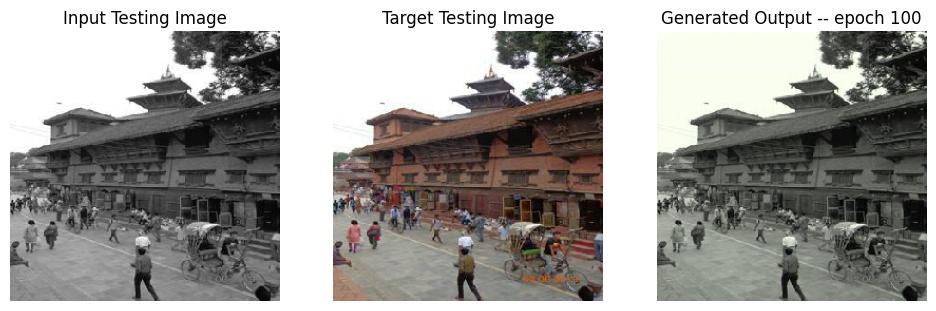

SSIM Score: 0.872185230255127
PSNR Score: 26.615825653076172
LPIPS Score: 0.7377087473869324
Perceptual Loss: 0.013867267407476902


In [40]:
display_random_test_image(gen, '/kaggle/input/monumentimagenotaugmented/val/Val_1000.jpg',100)

In [41]:
import random

each_epoch_train_generator_losses = []
each_epoch_train_generator_gan_losses = []
each_epoch_train_generator_l1_losses = []
each_epoch_train_generator_l2_losses = []
each_epoch_train_generator_perceptual_losses = []
each_epoch_train_discriminator_losses = []
each_epoch_train_discriminator_real_losses = []
each_epoch_train_discriminator_generated_losses = []
each_epoch_train_ssim = []
each_epoch_train_psnr = []
each_epoch_train_lpips = []
each_epoch_test_lpips = []
each_epoch_test_psnr = []
each_epoch_test_ssim = []
each_epoch_test_generator_losses = []
each_epoch_test_generator_gan_losses = []
each_epoch_test_generator_l1_losses = []
each_epoch_test_generator_l2_losses = []
each_epoch_test_generator_perceptual_losses = []
each_epoch_test_discriminator_losses = []
each_epoch_test_discriminator_real_losses = []
each_epoch_test_discriminator_generated_losses = []
train_generator_losses = []
train_generator_gan_losses = []
train_generator_l1_losses = []
train_generator_l2_losses = []
train_generator_perceptual_losses = []
train_discriminator_losses = []
train_discriminator_real_losses = []
train_discriminator_generated_losses = []
test_generator_losses = []
test_generator_gan_losses = []
test_generator_l1_losses = []
test_generator_l2_losses = []
test_generator_perceptual_losses = []
test_discriminator_losses = []
test_discriminator_real_losses = []
test_discriminator_generated_losses =[]
training_ssim = []
training_psnr = []
training_lpips = []
testing_ssim = []
testing_psnr = []
testing_lpips = []
each_epoch_all_records = []
all_records = []
def fit(train_ds, epochs, test_ds, gen_model):

    # Declare global lists
    global each_epoch_train_generator_losses, each_epoch_train_generator_gan_losses, each_epoch_train_generator_l1_losses, each_epoch_train_generator_l2_losses, each_epoch_train_generator_perceptual_losses, each_epoch_train_discriminator_losses,each_epoch_train_discriminator_real_losses, each_epoch_train_discriminator_generated_losses, each_epoch_train_ssim, each_epoch_train_psnr
    global each_epoch_test_psnr, each_epoch_test_ssim, each_epoch_test_generator_losses, each_epoch_test_generator_gan_losses, each_epoch_test_generator_l1_losses, each_epoch_test_generator_l2_losses, each_epoch_test_generator_perceptual_losses, each_epoch_test_discriminator_losses, each_epoch_test_discriminator_real_losses, each_epoch_test_discriminator_generated_losses
    global train_generator_losses, train_generator_gan_losses, train_generator_l1_losses, train_generator_l2_losses, train_generator_perceptual_losses, train_discriminator_losses, train_discriminator_real_losses, train_discriminator_generated_losses, test_generator_losses, test_generator_l2_losses, test_generator_gan_losses, test_generator_l1_losses, test_generator_perceptual_losses, test_discriminator_losses, test_discriminator_real_losses, test_discriminator_generated_losses
    global training_ssim, training_psnr, testing_ssim, testing_psnr, each_epoch_all_records, all_records, LAMBDA, each_epoch_train_lpips, each_epoch_test_lpips, training_lpips, testing_lpips


    # Initialize counters and flags
    consecutive_epochs_high_loss = 0
    training_discriminator = True
    stop_training = False
    min_learning_rate = 1e-7  # Set your desired minimum learning rate
    time_start = time.time()
    
    for epoch in range(epochs):
        start = time.time()
        train_count = 0
        test_count = 0

        print(f"Epoch {epoch}")

        for n, (input_, target) in train_ds.enumerate():
            if epoch > 10:
                train_gen_loss, train_gen_gan_loss, train_gen_l1_loss,train_gen_perceptual_loss, train_disc_loss, train_disc_real_loss, train_disc_generated_loss, train_ssim, train_psnr, train_lpips = train_step(input_, target, epoch, training_discriminator=training_discriminator)

            else:
                # If epoch is less than or equal to 10, train both generator and discriminator
                train_gen_loss, train_gen_gan_loss, train_gen_l1_loss, train_gen_perceptual_loss, train_disc_loss, train_disc_real_loss, train_disc_generated_loss, train_ssim, train_psnr, train_lpips  = train_step(input_, target, epoch, training_discriminator=None)

            each_epoch_train_generator_losses.append(train_gen_loss)
            each_epoch_train_generator_gan_losses.append(train_gen_gan_loss)
            each_epoch_train_generator_l1_losses.append(train_gen_l1_loss)
#             each_epoch_train_generator_l2_losses.append(train_gen_l2_loss)
            each_epoch_train_generator_perceptual_losses.append(train_gen_perceptual_loss)
            each_epoch_train_discriminator_losses.append(train_disc_loss)
            each_epoch_train_discriminator_real_losses.append(train_disc_real_loss)
            each_epoch_train_discriminator_generated_losses.append(train_disc_generated_loss)
            each_epoch_train_ssim.append(tf.reduce_mean(train_ssim.numpy()))
            each_epoch_train_psnr.append(tf.reduce_mean(train_psnr.numpy()))
            each_epoch_train_lpips.append(tf.reduce_mean(train_lpips.numpy()))
#             print(train_count)
            train_count += 1
#             print(n)
        #each_epoch_train_generator_losses = np.array(each_epoch_train_generator_losses)
        #print(each_epoch_train_discriminator_losses.shape())
        #print(each_epoch_train_generator_losses.shape())
        #print(each_epoch_train_ssim())
        print("Training Details")
        print("Generator-- total_loss:{:.5f} gan_loss:{:.5f} l1_loss:{:.5f} perceptual_loss:{:.5f} Discriminator-- total_loss:{:.5f} real_loss:{:.5f} generated_loss:{:.5f} --- SSIM {:.5f} PSNR {:.5f} LPIPS {:.5f}".format(np.mean(each_epoch_train_generator_losses),np.mean(each_epoch_train_generator_gan_losses), np.mean(each_epoch_train_generator_l1_losses),np.mean(each_epoch_train_generator_perceptual_losses), np.mean(each_epoch_train_discriminator_losses), np.mean(each_epoch_train_discriminator_generated_losses), np.mean(each_epoch_train_discriminator_real_losses), np.mean(each_epoch_train_ssim), np.mean(each_epoch_train_psnr), np.mean(each_epoch_train_lpips)))
        print("Time taken for epoch {} is {} sec".format(epoch + 1, time.time() - start))
        print(f"Number of iteration {train_count}")

        train_generator_losses.append(np.mean(each_epoch_train_generator_losses))
        train_generator_gan_losses.append(np.mean(each_epoch_train_generator_gan_losses))
        train_generator_l1_losses.append(np.mean(each_epoch_train_generator_l1_losses))
#         train_generator_l2_losses.append(np.mean(each_epoch_train_generator_l2_losses))
        train_generator_perceptual_losses.append(np.mean(each_epoch_train_generator_perceptual_losses))
        train_discriminator_losses.append(np.mean(each_epoch_train_discriminator_losses))
        train_discriminator_real_losses.append(np.mean(each_epoch_train_discriminator_real_losses))
        train_discriminator_generated_losses.append(np.mean(each_epoch_train_discriminator_generated_losses))
        training_ssim.append(np.mean(each_epoch_train_ssim))
        training_psnr.append(np.mean(each_epoch_train_psnr))
        training_lpips.append(np.mean(each_epoch_train_lpips))

        # Test
        for n, (input_, target) in test_ds.enumerate():
            test_gen_loss, test_gen_gan_loss, test_gen_l1_loss, test_gen_perceptual_loss, test_disc_loss, test_disc_real_loss, test_disc_generated_loss, test_ssim, test_psnr, test_lpips = test_step(input_, target)
            test_count += 1

            each_epoch_test_generator_losses.append(test_gen_loss)
            each_epoch_test_generator_gan_losses.append(test_gen_gan_loss)
            each_epoch_test_generator_l1_losses.append(test_gen_l1_loss)
#             each_epoch_test_generator_l2_losses.append(test_gen_l2_loss)
            each_epoch_test_generator_perceptual_losses.append(test_gen_perceptual_loss)
            each_epoch_test_discriminator_losses.append(test_disc_loss)
            each_epoch_test_discriminator_real_losses.append(test_disc_real_loss)
            each_epoch_test_discriminator_generated_losses.append(test_disc_generated_loss)
            each_epoch_test_ssim.append(tf.reduce_mean(test_ssim.numpy()))
            each_epoch_test_psnr.append(tf.reduce_mean(test_psnr.numpy()))
            each_epoch_test_lpips.append(tf.reduce_mean(test_lpips.numpy()))
    
        print("Testing Details")
        print("Generator-- total_loss:{:.5f} gan_loss:{:.5f} l1_loss:{:.5f}  perceptual_loss:{:.5f} Discriminator-- total_loss:{:.5f} real_loss:{:.5f} generated_loss:{:.5f} --- SSIM {:.5f} PSNR {:.5f} LPIPS {:.5f}".format(np.mean(each_epoch_test_generator_losses),np.mean(each_epoch_test_generator_gan_losses), np.mean(each_epoch_test_generator_l1_losses), np.mean(each_epoch_test_generator_perceptual_losses),np.mean(each_epoch_test_discriminator_losses), np.mean(each_epoch_test_discriminator_generated_losses), np.mean(each_epoch_test_discriminator_real_losses), np.mean(each_epoch_test_ssim), np.mean(each_epoch_test_psnr), np.mean(each_epoch_test_lpips)))
        print("Time taken for epoch {} is {} sec".format(epoch+1, time.time() - start))
        print(f"Number of iteration {test_count}")
#         LAMBDA = LAMBDA * 1.006
        test_generator_losses.append(np.mean(each_epoch_test_generator_losses))
        test_generator_gan_losses.append(np.mean(each_epoch_test_generator_gan_losses))
        test_generator_l1_losses.append(np.mean(each_epoch_test_generator_l1_losses))
#         test_generator_l2_losses.append(np.mean(each_epoch_test_generator_l2_losses))
        test_generator_perceptual_losses.append(np.mean(each_epoch_test_generator_perceptual_losses))
        test_discriminator_losses.append(np.mean(each_epoch_test_discriminator_losses))
        test_discriminator_real_losses.append(np.mean(each_epoch_test_discriminator_real_losses))
        test_discriminator_generated_losses.append(np.mean(each_epoch_test_discriminator_generated_losses))
        testing_ssim.append(np.mean(each_epoch_test_ssim))
        testing_psnr.append(np.mean(each_epoch_test_psnr))
        testing_lpips.append(np.mean(each_epoch_test_lpips))

        each_epoch_all_records.append([np.mean(each_epoch_train_generator_losses),np.mean(each_epoch_train_generator_gan_losses), np.mean(each_epoch_train_generator_l1_losses),np.mean(each_epoch_train_generator_perceptual_losses), np.mean(each_epoch_train_discriminator_losses), np.mean(each_epoch_train_discriminator_generated_losses), np.mean(each_epoch_train_discriminator_real_losses), np.mean(each_epoch_train_ssim), np.mean(each_epoch_train_psnr), np.mean(each_epoch_test_generator_losses),np.mean(each_epoch_test_generator_gan_losses), np.mean(each_epoch_test_generator_l1_losses),np.mean(each_epoch_test_generator_perceptual_losses),np.mean(each_epoch_test_discriminator_losses), np.mean(each_epoch_test_discriminator_generated_losses), np.mean(each_epoch_test_discriminator_real_losses), np.mean(each_epoch_test_ssim), np.mean(each_epoch_test_psnr)])
        all_records.append(each_epoch_all_records)
        # emptying for next epoch
        each_epoch_test_ssim = []
        each_epoch_test_generator_losses = []
        each_epoch_test_generator_gan_losses = []
        each_epoch_test_generator_l1_losses = []
#         each_epoch_test_generator_l2_losses = []
        each_epoch_test_generator_perceptual_losses = []
        each_epoch_test_discriminator_losses = []
        each_epoch_test_discriminator_real_losses = []
        each_epoch_test_discriminator_generated_losses = []
        each_epoch_test_psnr = []
        each_epoch_test_lpips = []
        each_epoch_all_records = []
        #emptyling list for next iteration
        each_epoch_train_generator_losses = []
        each_epoch_train_generator_gan_losses = []
        each_epoch_train_generator_l1_losses = []
#         each_epoch_train_generator_l2_losses = []
        each_epoch_train_generator_perceptual_losses = []
        each_epoch_train_discriminator_losses = []
        each_epoch_train_discriminator_real_losses = []
        each_epoch_train_discriminator_generated_losses = []
        each_epoch_train_ssim = []
        each_epoch_train_psnr = []
        each_epoch_train_lpips = []
        if time.time() - time_start > 40000:
            stop_training = True
        if epoch == 0 or epoch % 3 == 0:
            # Function to display one random test image
            # def display_random_test_image(images, labels, gen_model):
            #     # Randomly select an index
            #     random_test_image_idx = random.randint(0, len(images) - 1)

            #     # Extract input and target from the selected index
            #     random_test_input = images[random_test_image_idx]
            #     random_test_target = labels[random_test_image_idx]

            #     # Display the image
            #     display_one_random_test_image(random_test_input, random_test_target, gen_model)

            # Example usage
            display_random_test_image(gen, '/kaggle/input/monumentimagenotaugmented/val/Val_1000.jpg', epoch+1)
        # Check if the difference between two consecutive epochs for the last 5 epochs is less than 1
        if epoch > 10:
            # Check 1f the difference between two consecutive epochs for the last S epochs is less than 1 or 0.3
            last_epochs_losses = train_discriminator_losses[-5:] if training_discriminator else train_generator_losses[-5:]
            if all(((last_epochs_losses[i] - last_epochs_losses[i - 1])) < 0.01 if training_discriminator else ((last_epochs_losses[1] - last_epochs_losses[i - 1])) < 0.05 for i in range(1, 5)):
                consecutive_epochs_high_loss += 1
            else:
                consecutive_epochs_high_loss = 0
        
        
#         LAMBDA = LAMBDA*1.003
            # If the condition is met for 4 consecutive epochs, reduce the learning rate
        if consecutive_epochs_high_loss == 4:
            if training_discriminator:
                current_lr = generator_optimizer. learning_rate.numpy()
                new_lr = max (current_lr * 0.45, min_learning_rate)
                if new_lr > min_learning_rate:
                    generator_optimizer.learning_rate.assign(new_lr)
                    print (f"Reduced generator learning rate to {new_lr} at epoch {epoch + 1}")
                    # Switch training focus
                    training_discriminator = not training_discriminator
                else:
                    print(f"Generator learning rate already at the minimum. Stopping training.")
                    stop_training = True
            else:
                current_lr = discriminator_optimizer.learning_rate.numpy()
                new_lr = max (current_lr * 0.3, min_learning_rate)
                if new_lr > min_learning_rate:
                    discriminator_optimizer.learning_rate.assign(new_lr)
                    print(f"Reduced discriminator learning rate to {new_lr} at epoch {epoch + 1}.")
                    # Switch training focus
                    training_discriminator = not training_discriminator
                else:
                    print(f"Discriminator learning rate already at the minimum. Stopping training.")
                    stop_training = True

                consecutive_epochs_high_loss = 0
        # Check the flag variable
        if stop_training:
            break

In [42]:
tf.config.run_functions_eagerly(True)

Epoch 0
Training Details
Generator-- total_loss:2.62705 gan_loss:0.84001 l1_loss:0.04566 perceptual_loss:0.00834 Discriminator-- total_loss:1.43710 real_loss:0.72197 generated_loss:0.71513 --- SSIM 0.87427 PSNR 22.67894 LPIPS 1.27478
Time taken for epoch 1 is 1087.78786444664 sec
Number of iteration 980
Testing Details
Generator-- total_loss:2.94674 gan_loss:0.96700 l1_loss:0.05121  perceptual_loss:0.00887 Discriminator-- total_loss:1.40988 real_loss:0.59170 generated_loss:0.81818 --- SSIM 0.90566 PSNR 22.18203 LPIPS 1.32397
Time taken for epoch 1 is 1264.8155143260956 sec
Number of iteration 280
Displaying one random test image...


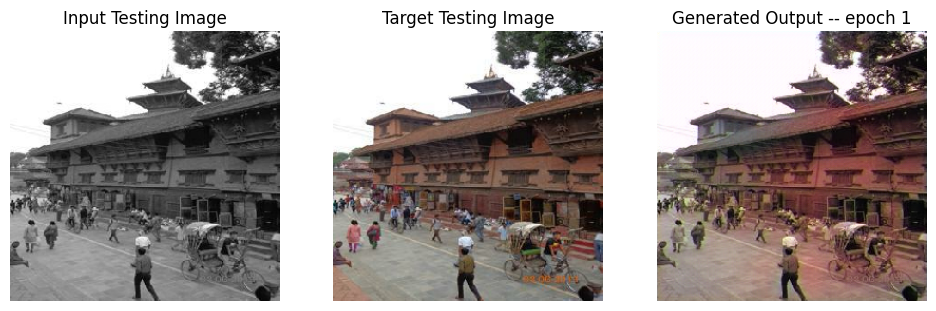

SSIM Score: 0.9458215832710266
PSNR Score: 26.716665267944336
LPIPS Score: 0.9029053449630737
Perceptual Loss: 0.0069734519347548485
Epoch 1
Training Details
Generator-- total_loss:2.54150 gan_loss:0.87786 l1_loss:0.04270 perceptual_loss:0.00765 Discriminator-- total_loss:1.55032 real_loss:0.77421 generated_loss:0.77611 --- SSIM 0.90700 PSNR 23.06270 LPIPS 1.19577
Time taken for epoch 2 is 1087.4018001556396 sec
Number of iteration 980
Testing Details
Generator-- total_loss:2.79398 gan_loss:0.83814 l1_loss:0.04957  perceptual_loss:0.00937 Discriminator-- total_loss:1.44604 real_loss:0.69495 generated_loss:0.75109 --- SSIM 0.92840 PSNR 22.23777 LPIPS 1.23737
Time taken for epoch 2 is 1265.3637523651123 sec
Number of iteration 280
Epoch 2
Training Details
Generator-- total_loss:2.37677 gan_loss:0.78230 l1_loss:0.04107 perceptual_loss:0.00725 Discriminator-- total_loss:1.37032 real_loss:0.67925 generated_loss:0.69107 --- SSIM 0.92847 PSNR 23.35258 LPIPS 1.14055
Time taken for epoch 3 is 1

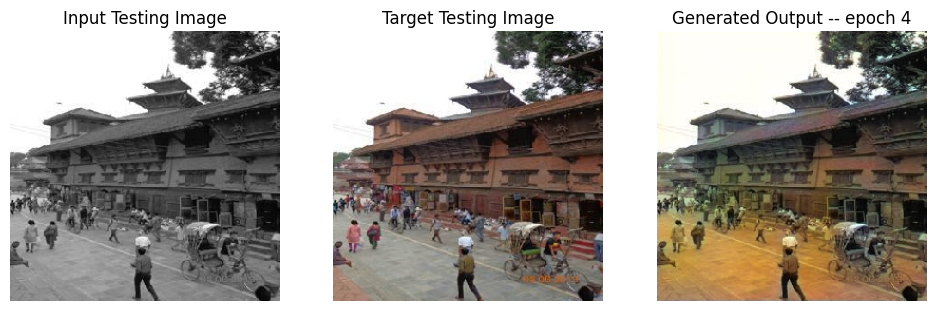

SSIM Score: 0.9488866925239563
PSNR Score: 21.6368350982666
LPIPS Score: 0.9433475136756897
Perceptual Loss: 0.008064303547143936
Epoch 4
Training Details
Generator-- total_loss:2.29942 gan_loss:0.76535 l1_loss:0.03949 perceptual_loss:0.00699 Discriminator-- total_loss:1.37454 real_loss:0.68162 generated_loss:0.69292 --- SSIM 0.93428 PSNR 23.55330 LPIPS 1.15399
Time taken for epoch 5 is 1095.6546988487244 sec
Number of iteration 980
Testing Details
Generator-- total_loss:2.13569 gan_loss:0.43423 l1_loss:0.04296  perceptual_loss:0.00825 Discriminator-- total_loss:1.56398 real_loss:1.10466 generated_loss:0.45932 --- SSIM 0.93654 PSNR 23.31038 LPIPS 1.18368
Time taken for epoch 5 is 1271.90758061409 sec
Number of iteration 280
Epoch 5
Training Details
Generator-- total_loss:2.28271 gan_loss:0.76571 l1_loss:0.03904 perceptual_loss:0.00692 Discriminator-- total_loss:1.37410 real_loss:0.68297 generated_loss:0.69113 --- SSIM 0.93380 PSNR 23.64745 LPIPS 1.16552
Time taken for epoch 6 is 1092.1

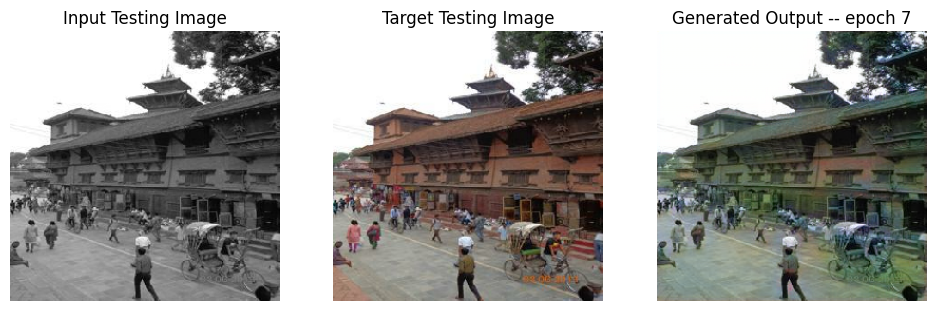

SSIM Score: 0.9598638415336609
PSNR Score: 25.888723373413086
LPIPS Score: 0.8884106874465942
Perceptual Loss: 0.005692025646567345
Epoch 7
Training Details
Generator-- total_loss:2.27018 gan_loss:0.76274 l1_loss:0.03869 perceptual_loss:0.00694 Discriminator-- total_loss:1.36404 real_loss:0.67779 generated_loss:0.68625 --- SSIM 0.93272 PSNR 23.70266 LPIPS 1.18991
Time taken for epoch 8 is 1082.3020408153534 sec
Number of iteration 980
Testing Details
Generator-- total_loss:2.33164 gan_loss:0.61030 l1_loss:0.04389  perceptual_loss:0.00809 Discriminator-- total_loss:1.37722 real_loss:0.80449 generated_loss:0.57273 --- SSIM 0.93990 PSNR 23.37536 LPIPS 1.16135
Time taken for epoch 8 is 1255.4794471263885 sec
Number of iteration 280
Epoch 8
Training Details
Generator-- total_loss:2.26464 gan_loss:0.76019 l1_loss:0.03852 perceptual_loss:0.00698 Discriminator-- total_loss:1.36357 real_loss:0.67865 generated_loss:0.68492 --- SSIM 0.93378 PSNR 23.75924 LPIPS 1.20211
Time taken for epoch 9 is 10

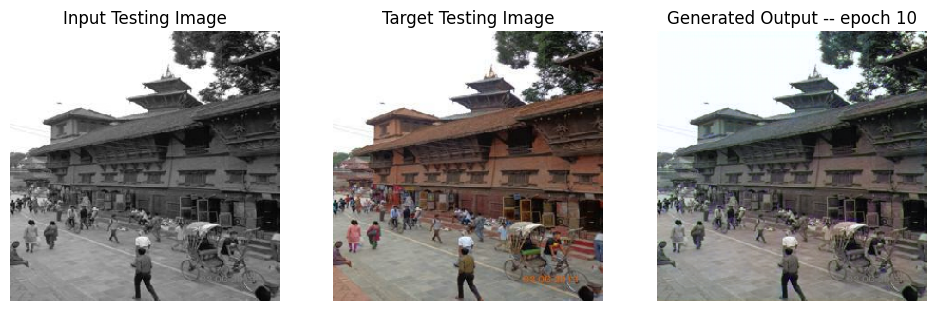

SSIM Score: 0.9660191535949707
PSNR Score: 27.186126708984375
LPIPS Score: 0.793769121170044
Perceptual Loss: 0.007389564998447895
Epoch 10
Training Details
Generator-- total_loss:1.84236 gan_loss:0.39050 l1_loss:0.03659 perceptual_loss:0.00708 Discriminator-- total_loss:1.83416 real_loss:1.24259 generated_loss:0.59158 --- SSIM 0.94351 PSNR 23.43004 LPIPS 1.61740
Time taken for epoch 11 is 914.3025057315826 sec
Number of iteration 980
Testing Details
Generator-- total_loss:2.24201 gan_loss:0.45273 l1_loss:0.04503  perceptual_loss:0.00877 Discriminator-- total_loss:1.53598 real_loss:1.08391 generated_loss:0.45207 --- SSIM 0.93636 PSNR 22.60710 LPIPS 1.73420
Time taken for epoch 11 is 1086.5795004367828 sec
Number of iteration 280
Epoch 11
Training Details
Generator-- total_loss:10.27160 gan_loss:8.86703 l1_loss:0.03541 perceptual_loss:0.00685 Discriminator-- total_loss:0.03386 real_loss:0.01772 generated_loss:0.01614 --- SSIM 0.94538 PSNR 23.75296 LPIPS 1.59092
Time taken for epoch 12 i

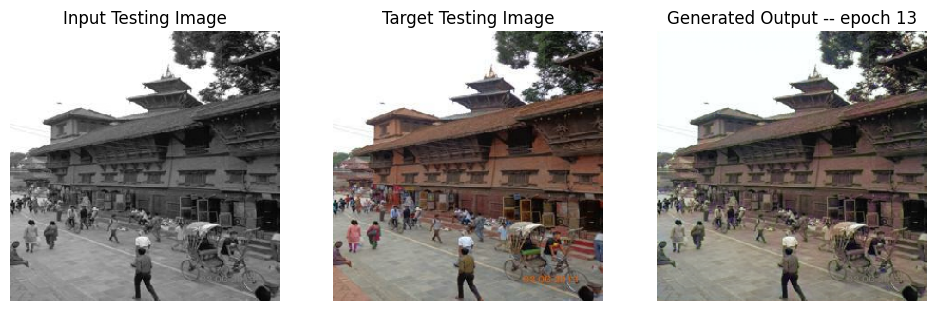

SSIM Score: 0.9734414219856262
PSNR Score: 29.8928165435791
LPIPS Score: 0.6931091547012329
Perceptual Loss: 0.0048261662013828754
Epoch 13
Training Details
Generator-- total_loss:15.17524 gan_loss:13.76951 l1_loss:0.03546 perceptual_loss:0.00684 Discriminator-- total_loss:0.00826 real_loss:0.00384 generated_loss:0.00442 --- SSIM 0.94508 PSNR 23.72812 LPIPS 1.60206
Time taken for epoch 14 is 761.934335231781 sec
Number of iteration 980
Testing Details
Generator-- total_loss:5.86186 gan_loss:4.23589 l1_loss:0.04074  perceptual_loss:0.00808 Discriminator-- total_loss:2.40784 real_loss:0.62585 generated_loss:1.78198 --- SSIM 0.93877 PSNR 23.49126 LPIPS 1.63992
Time taken for epoch 14 is 936.2468168735504 sec
Number of iteration 280
Epoch 14
Training Details
Generator-- total_loss:16.35647 gan_loss:14.95231 l1_loss:0.03542 perceptual_loss:0.00683 Discriminator-- total_loss:0.00092 real_loss:0.00066 generated_loss:0.00026 --- SSIM 0.94538 PSNR 23.74293 LPIPS 1.59230
Time taken for epoch 15 

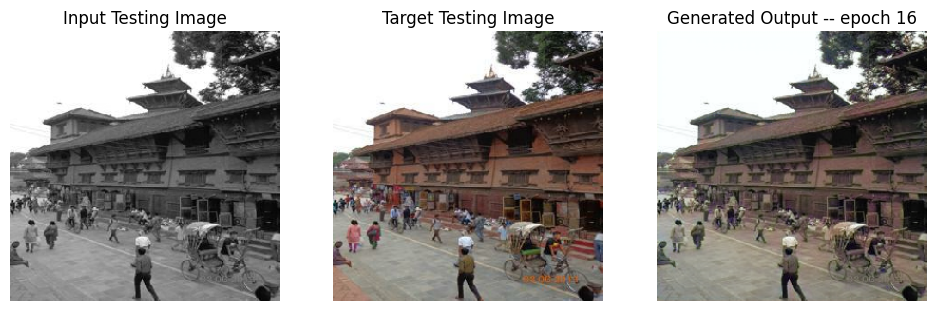

SSIM Score: 0.9734966158866882
PSNR Score: 29.91706657409668
LPIPS Score: 0.6923466920852661
Perceptual Loss: 0.004824570380151272
Epoch 16
Training Details
Generator-- total_loss:16.50984 gan_loss:15.10563 l1_loss:0.03542 perceptual_loss:0.00683 Discriminator-- total_loss:0.00002 real_loss:0.00001 generated_loss:0.00000 --- SSIM 0.94536 PSNR 23.76359 LPIPS 1.59167
Time taken for epoch 17 is 747.894412279129 sec
Number of iteration 980
Testing Details
Generator-- total_loss:5.28350 gan_loss:3.67806 l1_loss:0.04025  perceptual_loss:0.00796 Discriminator-- total_loss:2.33645 real_loss:0.73938 generated_loss:1.59708 --- SSIM 0.94018 PSNR 23.58213 LPIPS 1.55809
Time taken for epoch 17 is 920.0052483081818 sec
Number of iteration 280
Epoch 17
Training Details
Generator-- total_loss:17.64070 gan_loss:16.23902 l1_loss:0.03537 perceptual_loss:0.00681 Discriminator-- total_loss:0.11979 real_loss:0.07107 generated_loss:0.04872 --- SSIM 0.94561 PSNR 23.76484 LPIPS 1.58703
Time taken for epoch 18 

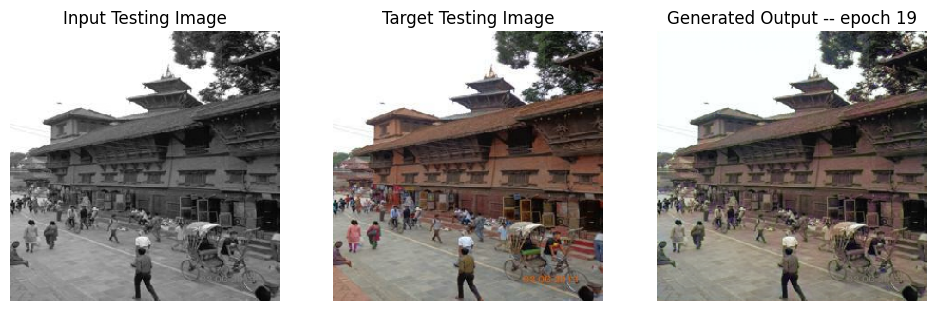

SSIM Score: 0.9734330177307129
PSNR Score: 29.93487548828125
LPIPS Score: 0.6953099370002747
Perceptual Loss: 0.004824257455766201
Epoch 19
Training Details
Generator-- total_loss:13.50300 gan_loss:12.09733 l1_loss:0.03544 perceptual_loss:0.00685 Discriminator-- total_loss:0.00115 real_loss:0.00060 generated_loss:0.00055 --- SSIM 0.94538 PSNR 23.74369 LPIPS 1.59810
Time taken for epoch 20 is 745.2339072227478 sec
Number of iteration 980
Testing Details
Generator-- total_loss:3.92528 gan_loss:2.30571 l1_loss:0.04057  perceptual_loss:0.00805 Discriminator-- total_loss:2.83558 real_loss:1.44541 generated_loss:1.39017 --- SSIM 0.93926 PSNR 23.50250 LPIPS 1.62391
Time taken for epoch 20 is 918.8606967926025 sec
Number of iteration 280
Epoch 20
Training Details
Generator-- total_loss:15.64317 gan_loss:14.24135 l1_loss:0.03536 perceptual_loss:0.00682 Discriminator-- total_loss:0.00004 real_loss:0.00002 generated_loss:0.00002 --- SSIM 0.94541 PSNR 23.77354 LPIPS 1.58943
Time taken for epoch 21

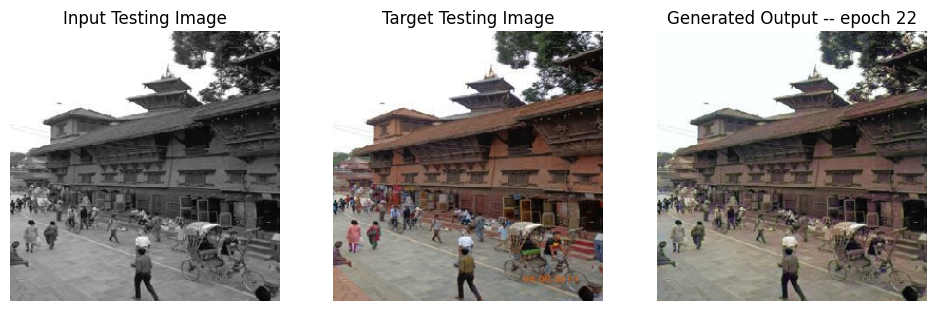

SSIM Score: 0.9735250473022461
PSNR Score: 29.923158645629883
LPIPS Score: 0.693678617477417
Perceptual Loss: 0.004841078072786331
Epoch 22
Training Details
Generator-- total_loss:28.31167 gan_loss:26.90749 l1_loss:0.03541 perceptual_loss:0.00684 Discriminator-- total_loss:0.00416 real_loss:0.00217 generated_loss:0.00199 --- SSIM 0.94534 PSNR 23.75076 LPIPS 1.59126
Time taken for epoch 23 is 743.2455244064331 sec
Number of iteration 980
Testing Details
Generator-- total_loss:10.41310 gan_loss:8.80495 l1_loss:0.04033  perceptual_loss:0.00797 Discriminator-- total_loss:6.37737 real_loss:2.10989 generated_loss:4.26749 --- SSIM 0.93980 PSNR 23.57181 LPIPS 1.57177
Time taken for epoch 23 is 916.5559766292572 sec
Number of iteration 280
Epoch 23
Training Details
Generator-- total_loss:20.50065 gan_loss:19.09690 l1_loss:0.03542 perceptual_loss:0.00682 Discriminator-- total_loss:0.00874 real_loss:0.00302 generated_loss:0.00572 --- SSIM 0.94520 PSNR 23.76512 LPIPS 1.59271
Time taken for epoch 2

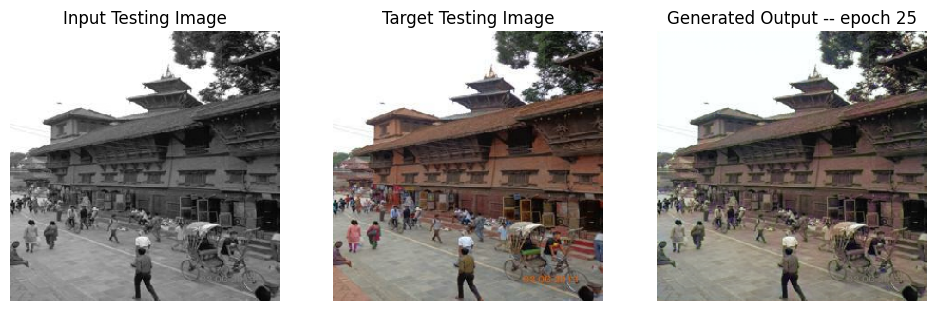

SSIM Score: 0.9734720587730408
PSNR Score: 29.900054931640625
LPIPS Score: 0.6931958198547363
Perceptual Loss: 0.004830989986658096
Epoch 25
Training Details
Generator-- total_loss:26.92278 gan_loss:25.51716 l1_loss:0.03544 perceptual_loss:0.00685 Discriminator-- total_loss:0.01464 real_loss:0.00711 generated_loss:0.00753 --- SSIM 0.94532 PSNR 23.72932 LPIPS 1.59416
Time taken for epoch 26 is 746.4031445980072 sec
Number of iteration 980
Testing Details
Generator-- total_loss:5.81624 gan_loss:4.19891 l1_loss:0.04050  perceptual_loss:0.00805 Discriminator-- total_loss:6.55107 real_loss:5.04062 generated_loss:1.51045 --- SSIM 0.93930 PSNR 23.52155 LPIPS 1.62517
Time taken for epoch 26 is 920.404896736145 sec
Number of iteration 280
Epoch 26
Training Details
Generator-- total_loss:28.20152 gan_loss:26.79599 l1_loss:0.03544 perceptual_loss:0.00685 Discriminator-- total_loss:0.00003 real_loss:0.00002 generated_loss:0.00000 --- SSIM 0.94540 PSNR 23.74775 LPIPS 1.59122
Time taken for epoch 27

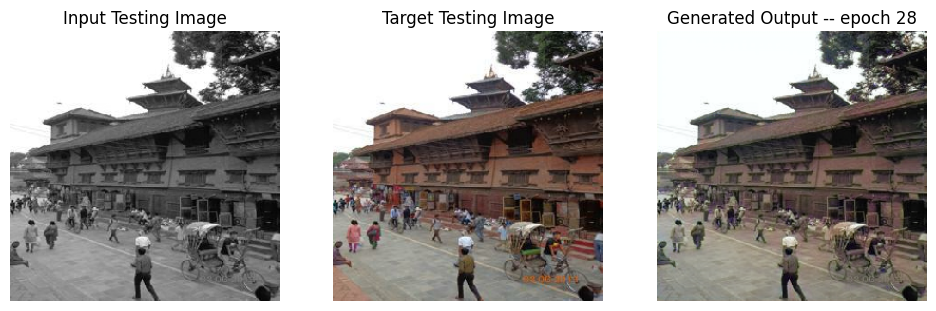

SSIM Score: 0.973501980304718
PSNR Score: 29.900827407836914
LPIPS Score: 0.6930162906646729
Perceptual Loss: 0.004842859692871571
Epoch 28
Training Details
Generator-- total_loss:32.41514 gan_loss:31.01095 l1_loss:0.03543 perceptual_loss:0.00682 Discriminator-- total_loss:0.04816 real_loss:0.03309 generated_loss:0.01506 --- SSIM 0.94539 PSNR 23.75836 LPIPS 1.59135
Time taken for epoch 29 is 745.5353848934174 sec
Number of iteration 980
Testing Details
Generator-- total_loss:13.18827 gan_loss:11.58666 l1_loss:0.04018  perceptual_loss:0.00793 Discriminator-- total_loss:28.92140 real_loss:23.43543 generated_loss:5.48597 --- SSIM 0.94015 PSNR 23.61506 LPIPS 1.54584
Time taken for epoch 29 is 915.7946608066559 sec
Number of iteration 280
Epoch 29
Training Details
Generator-- total_loss:65.80779 gan_loss:64.39906 l1_loss:0.03552 perceptual_loss:0.00686 Discriminator-- total_loss:0.01025 real_loss:0.00724 generated_loss:0.00301 --- SSIM 0.94523 PSNR 23.75566 LPIPS 1.59398
Time taken for epoc

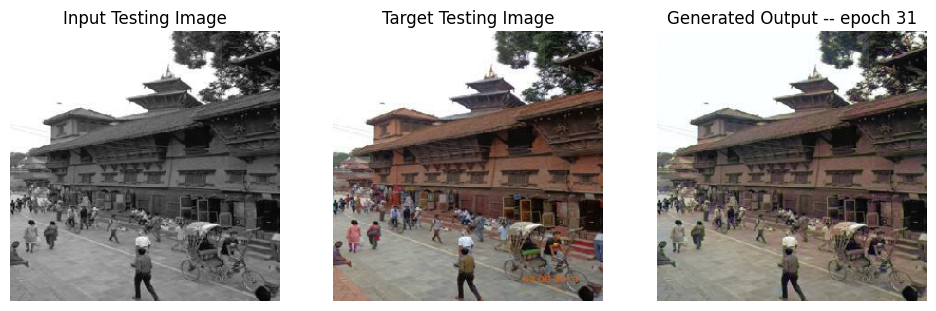

SSIM Score: 0.9734129309654236
PSNR Score: 29.924795150756836
LPIPS Score: 0.6947758793830872
Perceptual Loss: 0.0048225270584225655
Epoch 31
Training Details
Generator-- total_loss:46.09131 gan_loss:44.68679 l1_loss:0.03541 perceptual_loss:0.00684 Discriminator-- total_loss:0.00036 real_loss:0.00016 generated_loss:0.00020 --- SSIM 0.94544 PSNR 23.76617 LPIPS 1.59395
Time taken for epoch 32 is 747.6242933273315 sec
Number of iteration 980
Testing Details
Generator-- total_loss:11.10372 gan_loss:9.47284 l1_loss:0.04080  perceptual_loss:0.00814 Discriminator-- total_loss:15.82033 real_loss:14.27317 generated_loss:1.54716 --- SSIM 0.93852 PSNR 23.45362 LPIPS 1.68357
Time taken for epoch 32 is 920.549863576889 sec
Number of iteration 280
Epoch 32
Training Details
Generator-- total_loss:49.06104 gan_loss:47.65604 l1_loss:0.03544 perceptual_loss:0.00684 Discriminator-- total_loss:0.00002 real_loss:0.00001 generated_loss:0.00002 --- SSIM 0.94538 PSNR 23.75161 LPIPS 1.59131
Time taken for epoc

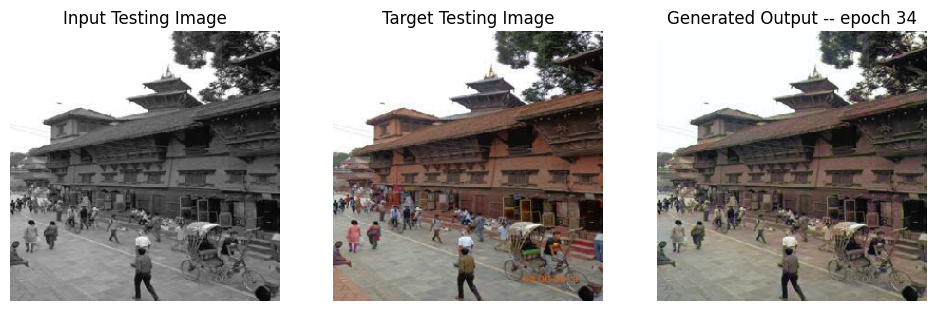

SSIM Score: 0.9734227657318115
PSNR Score: 29.904043197631836
LPIPS Score: 0.6941264867782593
Perceptual Loss: 0.0048183477483689785
Epoch 34
Training Details
Generator-- total_loss:47.78568 gan_loss:46.38185 l1_loss:0.03540 perceptual_loss:0.00683 Discriminator-- total_loss:0.01691 real_loss:0.00896 generated_loss:0.00796 --- SSIM 0.94533 PSNR 23.74246 LPIPS 1.59330
Time taken for epoch 35 is 754.6062762737274 sec
Number of iteration 980
Testing Details
Generator-- total_loss:12.29465 gan_loss:10.68993 l1_loss:0.04024  perceptual_loss:0.00795 Discriminator-- total_loss:6.80489 real_loss:3.17358 generated_loss:3.63131 --- SSIM 0.93993 PSNR 23.59102 LPIPS 1.55983
Time taken for epoch 35 is 928.435378074646 sec
Number of iteration 280
Epoch 35
Training Details
Generator-- total_loss:43.08409 gan_loss:41.68209 l1_loss:0.03537 perceptual_loss:0.00682 Discriminator-- total_loss:0.00004 real_loss:0.00003 generated_loss:0.00001 --- SSIM 0.94541 PSNR 23.74405 LPIPS 1.59898
Time taken for epoch

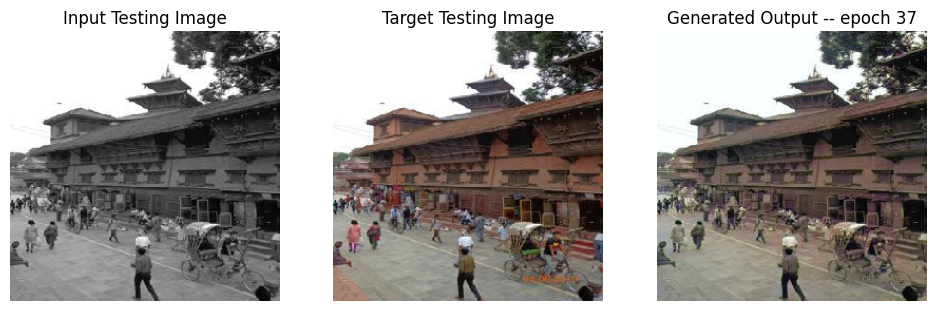

SSIM Score: 0.9734569191932678
PSNR Score: 29.91867446899414
LPIPS Score: 0.6932178139686584
Perceptual Loss: 0.00482341181486845
Epoch 37
Training Details
Generator-- total_loss:56.56139 gan_loss:55.15558 l1_loss:0.03546 perceptual_loss:0.00684 Discriminator-- total_loss:0.04710 real_loss:0.00727 generated_loss:0.03983 --- SSIM 0.94528 PSNR 23.76222 LPIPS 1.59545
Time taken for epoch 38 is 743.6018495559692 sec
Number of iteration 980
Testing Details
Generator-- total_loss:10.63966 gan_loss:9.00001 l1_loss:0.04101  perceptual_loss:0.00819 Discriminator-- total_loss:18.05009 real_loss:16.48207 generated_loss:1.56802 --- SSIM 0.93813 PSNR 23.40336 LPIPS 1.71673
Time taken for epoch 38 is 919.7884676456451 sec
Number of iteration 280
Epoch 38
Training Details
Generator-- total_loss:52.50863 gan_loss:51.10405 l1_loss:0.03544 perceptual_loss:0.00683 Discriminator-- total_loss:0.00005 real_loss:0.00005 generated_loss:0.00001 --- SSIM 0.94528 PSNR 23.74339 LPIPS 1.59567
Time taken for epoch 

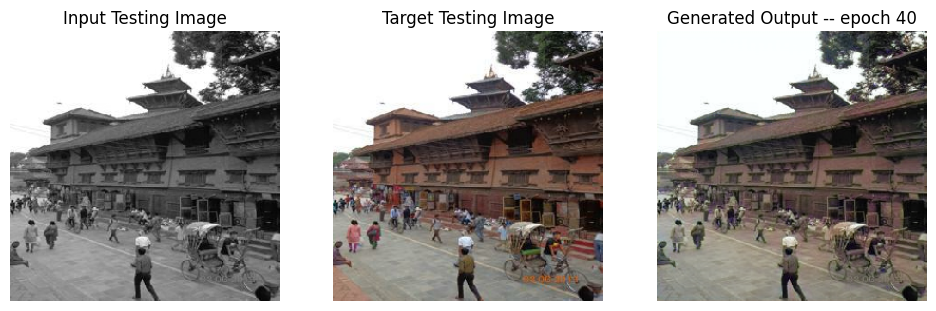

SSIM Score: 0.973484992980957
PSNR Score: 29.92426300048828
LPIPS Score: 0.6930849552154541
Perceptual Loss: 0.004820866044610739


In [43]:
fit(train_dataset, epochs, test_dataset, gen)

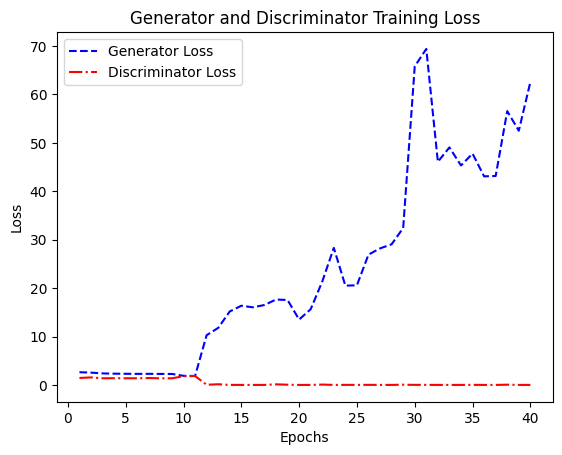

In [44]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_losses, '--b', label='Generator Loss')
plt.plot(epochs, train_discriminator_losses, '-.r', label='Discriminator Loss')
plt.title('Generator and Discriminator Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/train_loss_plot_1.png')
plt.show()

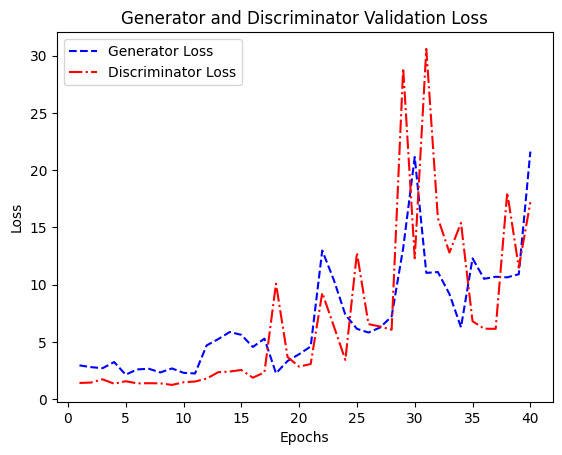

In [45]:
epochs = range(1, len(test_generator_losses) + 1)

plt.plot(epochs, test_generator_losses, '--b', label='Generator Loss')
plt.plot(epochs, test_discriminator_losses, '-.r', label='Discriminator Loss')
plt.title('Generator and Discriminator Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/test_loss_plot_1.png')
plt.show()

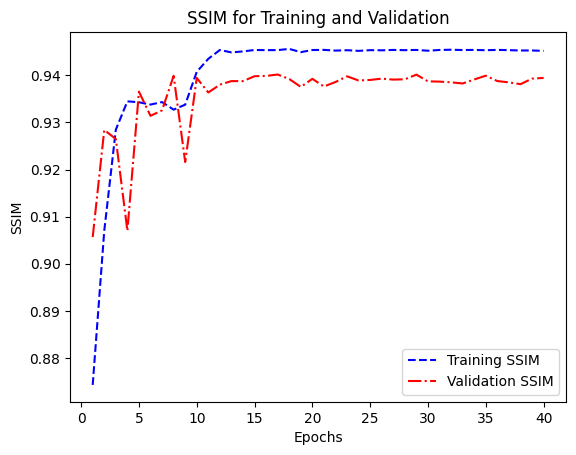

In [46]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, training_ssim, '--b', label='Training SSIM')
plt.plot(epochs, testing_ssim, '-.r', label='Validation SSIM')
plt.title('SSIM for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.legend()
plt.savefig('/kaggle/working/SSIM_plot_1.png')
plt.show()

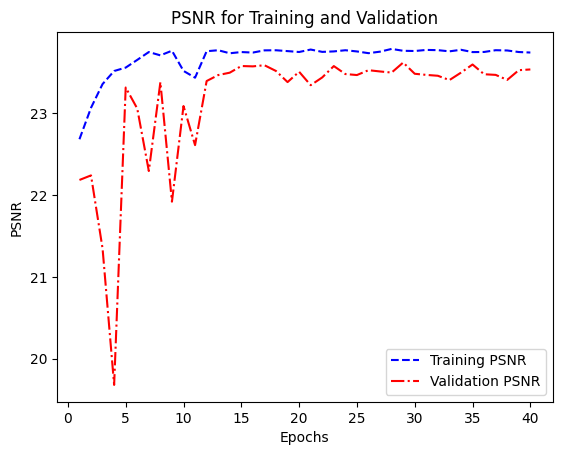

In [47]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, training_psnr, '--b', label='Training PSNR')
plt.plot(epochs, testing_psnr, '-.r', label='Validation PSNR')
plt.title('PSNR for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()
plt.savefig('/kaggle/working/PSNR_plot_1.png')
plt.show()

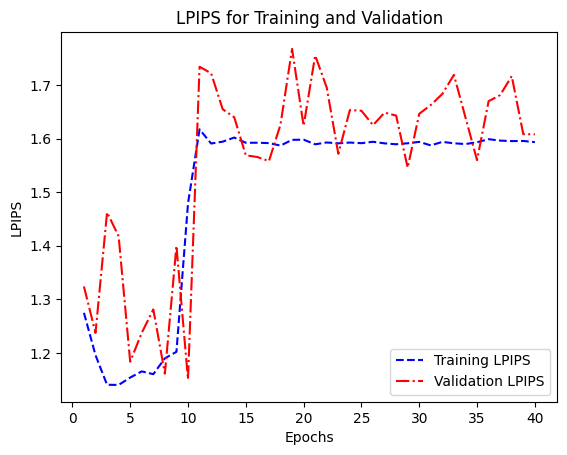

In [48]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, training_lpips, '--b', label='Training LPIPS')
plt.plot(epochs, testing_lpips, '-.r', label='Validation LPIPS')
plt.title('LPIPS for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('LPIPS')
plt.legend()
plt.savefig('/kaggle/working/LPIPS_plot_1.png')
plt.show()

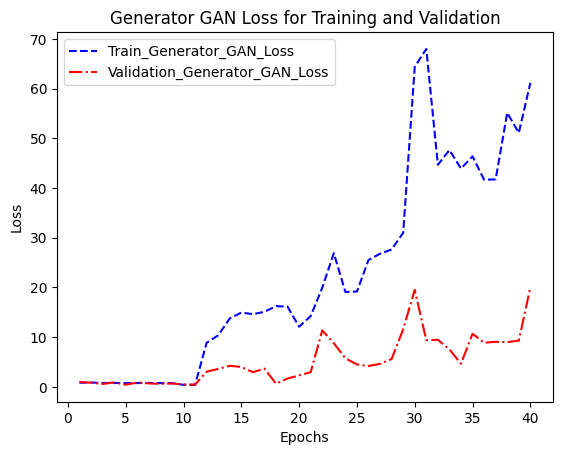

In [49]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_gan_losses, '--b', label='Train_Generator_GAN_Loss')
plt.plot(epochs, test_generator_gan_losses, '-.r', label='Validation_Generator_GAN_Loss')
plt.title('Generator GAN Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_GAN_plot_1.png')
plt.show()

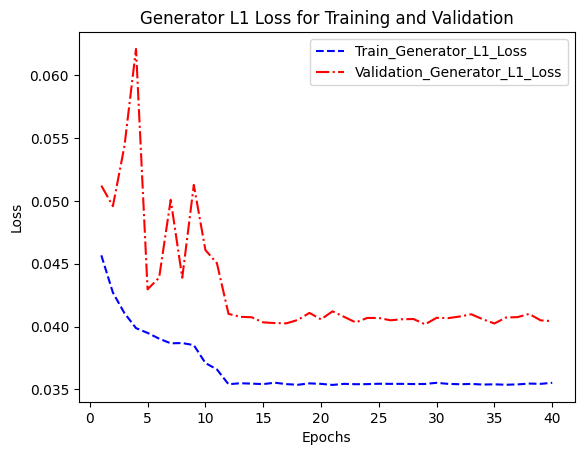

In [50]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_l1_losses, '--b', label='Train_Generator_L1_Loss')
plt.plot(epochs, test_generator_l1_losses, '-.r', label='Validation_Generator_L1_Loss')
plt.title('Generator L1 Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_L1_plot_1.png')
plt.show()

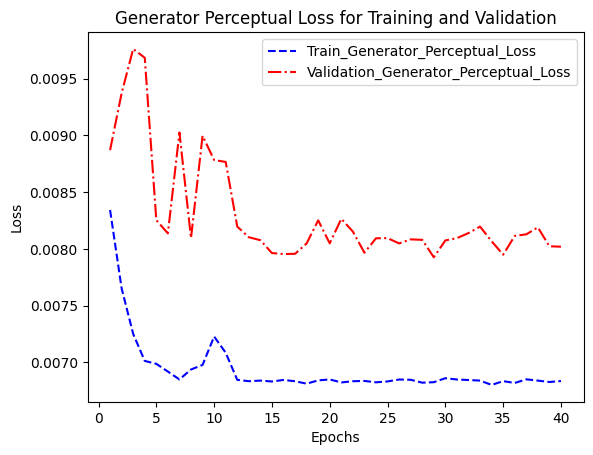

In [51]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_perceptual_losses, '--b', label='Train_Generator_Perceptual_Loss')
plt.plot(epochs, test_generator_perceptual_losses, '-.r', label='Validation_Generator_Perceptual_Loss')
plt.title('Generator Perceptual Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_Perceptual_plot_1.png')
plt.show()

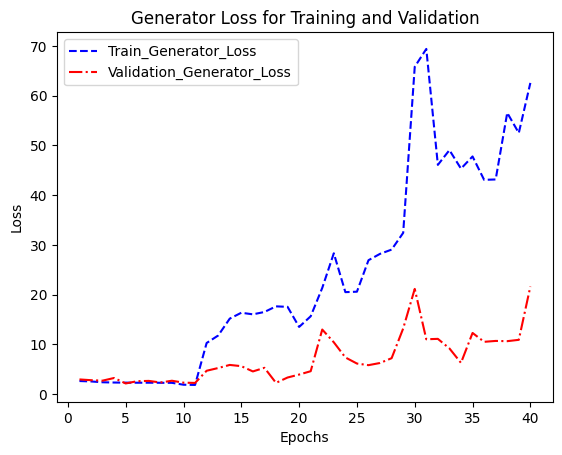

In [52]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_generator_losses, '--b', label='Train_Generator_Loss')
plt.plot(epochs, test_generator_losses, '-.r', label='Validation_Generator_Loss')
plt.title('Generator Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Gen_plot_1.png')
plt.show()

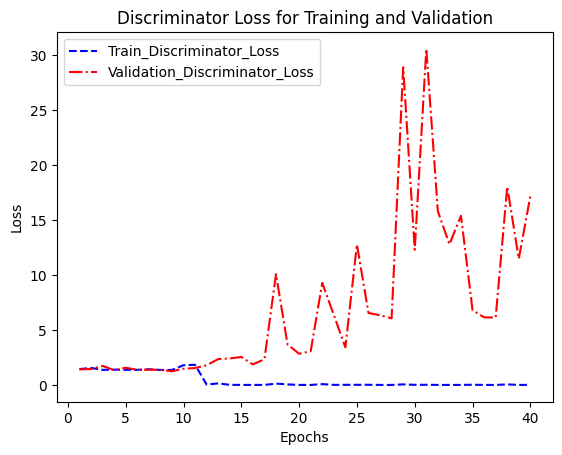

In [53]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_discriminator_losses, '--b', label='Train_Discriminator_Loss')
plt.plot(epochs, test_discriminator_losses, '-.r', label='Validation_Discriminator_Loss')
plt.title('Discriminator Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Disc_plot_1.png')
plt.show()

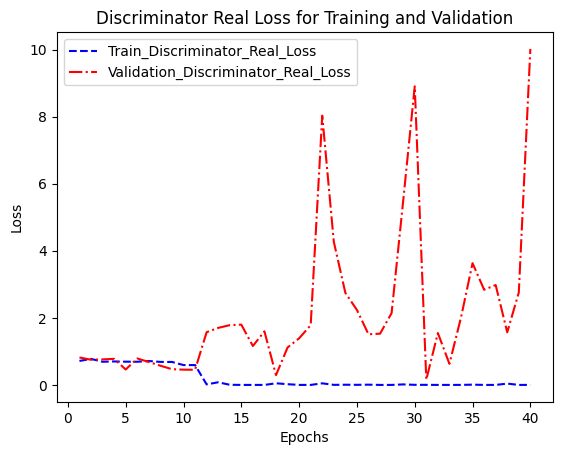

In [54]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_discriminator_real_losses, '--b', label='Train_Discriminator_Real_Loss')
plt.plot(epochs, test_discriminator_real_losses, '-.r', label='Validation_Discriminator_Real_Loss')
plt.title('Discriminator Real Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Disc_Real_plot_1.png')
plt.show()

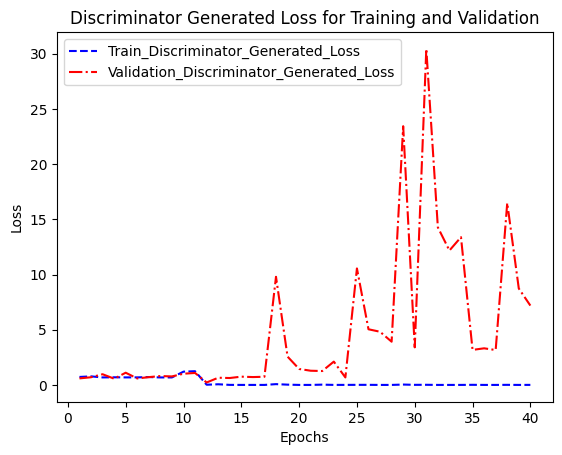

In [55]:
epochs = range(1, len(train_generator_losses) + 1)

plt.plot(epochs, train_discriminator_generated_losses, '--b', label='Train_Discriminator_Generated_Loss')
plt.plot(epochs, test_discriminator_generated_losses, '-.r', label='Validation_Discriminator_Generated_Loss')
plt.title('Discriminator Generated Loss for Training and Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/kaggle/working/Disc_Generated_plot_1.png')
plt.show()

In [56]:
import csv
with open('/kaggle/working/dataJan20.csv','w', newline='') as file:
    writer = csv.writer(file)
    writer.writerows(all_records)

In [57]:
os.mkdir('/kaggle/working/modelsFeb7')

In [58]:
gen.save('/kaggle/working/modelsFeb7/gen.h5')
gen.save_weights('/kaggle/working/modelsFeb7/gen.keras')
disc.save('/kaggle/working/modelsFeb7/disc.h5')
disc.save_weights('/kaggle/working/modelsFeb7/disc.keras')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [59]:
def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode !=0:
        print("Unable to run zip command")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [60]:
import subprocess
from IPython.display import FileLink, display

In [61]:
download_file('/kaggle/working', 'outputFeb8')

/kaggle/working/outputFeb8.zip